# Optimizing Model - Optuna Parameter Optimization for LightGBM

In [126]:
## Model Iteration 5
## Feature Eng: Parameter optimization using Optuna model for LightGBM,  
##              Parameter optimization using gridsearchcv model for XGBoost,  
## Purpose: To measure the effects of parameter optimization
## Results : 
##      LightGBM Model RMSE is:  36.81037880022666 (-4.19% change)
##      LightGBM Model R2 Score is:  0.25150748630315467 (34.70% change)
##      LightGBM Model Cross-validation MAE is: 21.608509540616378 (-2.54% change)
##      XGBoostModel RMSE is:  41.648609711673814
##      XGBoost Model R2 Score is:  0.05225789444813955
##      XGBoost Model Cross-validation MAE is: 22.453367

In [127]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split

In [128]:
data_flight_info = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/Regression_no_outliers_cleaned_data_03.csv', sep = ',')

In [129]:
data_flight_info.shape

(979648, 24)

In [130]:
data_weather = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/weather.csv', sep = ',')

In [131]:
data_weather.shape

(14099, 39)

In [132]:
df_flight_info = data_flight_info.copy()
df_weather = data_weather.copy()

In [133]:
#Only want top 19 busiest airports
airports = ['ORD','ATL','DFW','DEN','LAX','CLT','SEA','SFO','EWR','LGA','PHX','IAH','LAS','BOS','MCO','DTW','PHIL','DCA','MSP']
df_flight_info = df_flight_info[df_flight_info['origin'].isin(airports)]
df_flight_info.origin.value_counts()

ATL    48923
ORD    48428
DFW    35688
DEN    33907
LAX    30969
CLT    30851
SEA    23313
PHX    22252
SFO    22183
IAH    22017
DTW    21795
LAS    20661
LGA    20597
MSP    19965
EWR    19453
BOS    18365
MCO    17474
DCA    17438
Name: origin, dtype: int64

In [134]:
df_weather['value'] = df_weather['value'].str.lower()
# create a list of our conditions
conditions = [
    (df_weather['value'].str.contains('sunny')),
    (df_weather['value'].str.contains('cloud')),
    (df_weather['value'].str.contains('mist')),
    (df_weather['value'].str.contains('fog')),
    (df_weather['value'].str.contains('overcast')),
    (df_weather['value'].str.contains('rain')),
    (df_weather['value'].str.contains('drizzle')),
    (df_weather['value'].str.contains('thunder')),
    (df_weather['value'].str.contains('snow')),
    (df_weather['value'].str.contains('sleet')),
    (df_weather['value'].str.contains('blizzard')),
    ]

# create a list of the values we want to assign for each condition
values = ['sunny', 'cloudy', 'cloudy','cloudy','cloudy','rain','rain','rain','snow','snow','snow']

# create a new column and use np.select to assign values to it using our lists as arguments
df_weather['weather_type'] = np.select(conditions, values)
df_weather['weather_type'].value_counts()

sunny     5503
cloudy    4324
rain      2860
snow      1412
Name: weather_type, dtype: int64

In [135]:
df_weather['value'].value_counts().sum()

14099

In [136]:
# Creating year, month, date columns
df_weather['year'] = pd.DatetimeIndex(df_weather['date']).year
df_weather['month'] = pd.DatetimeIndex(df_weather['date']).month
df_weather['day'] = pd.DatetimeIndex(df_weather['date']).day
df_weather['weekday'] = ((pd.DatetimeIndex(df_weather['date']).dayofweek))

#### Merging weather data with flight data

In [137]:
df_weather.rename(columns={'date': 'fl_date', 'airport_code': 'origin'}, inplace=True)

In [138]:
df_flight_info = pd.merge(df_flight_info, df_weather[['fl_date','origin','weather_type']],  how='left', left_on=['fl_date','origin'], right_on = ['fl_date','origin'])


In [139]:
df_flight_info.shape

(518202, 25)

In [140]:
# Dropping the small number of null weather types
df_flight_info = df_flight_info.dropna()

In [141]:
# Finding average route times
df_flight_info['flight_number'] = df_flight_info['op_unique_carrier'] + df_flight_info['op_carrier_fl_num'].astype(str)
route_time_grouped = df_flight_info.groupby(by='flight_number').mean()
route_time_grouped.reset_index(inplace=True)
route_time_grouped['average_route_time'] = route_time_grouped['actual_elapsed_time']
route_time_grouped = route_time_grouped[['flight_number','average_route_time']]

In [142]:
# Getting Average Carrier Delay - Grouped by Carrier
carrier_grouped = df_flight_info.groupby(by='op_unique_carrier').mean()
carrier_grouped.reset_index(inplace=True)
carrier_grouped['total_carrier_delay'] = carrier_grouped['carrier_delay'] + carrier_grouped['late_aircraft_delay']
carrier_grouped = carrier_grouped[['op_unique_carrier', 'total_carrier_delay']]

In [143]:
# Getting Average Weather Delay
weather_grouped1 = df_flight_info.groupby(by=['origin','month']).mean()
weather_grouped1.reset_index(inplace=True)
weather_grouped1['total_weather_delay'] = weather_grouped1['weather_delay']
weather_grouped1 = weather_grouped1[['origin','total_weather_delay']]

In [144]:
# Getting Average NAS Delay - Grouped by Flight Number
nas_grouped = df_flight_info.groupby(by='flight_number').mean()
nas_grouped.reset_index(inplace=True)
nas_grouped['total_nas_delay'] = nas_grouped['nas_delay']
nas_grouped = nas_grouped[['flight_number', 'total_nas_delay']]

# Getting Average Security Delay
security_grouped = df_flight_info.groupby(by='origin').mean()
security_grouped.reset_index(inplace=True)
security_grouped['total_security_delay'] = security_grouped['security_delay']
security_grouped = security_grouped[['origin','total_security_delay']]

# Getting Average Departure Delays by Route
dep_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
dep_delay_grouped.reset_index(inplace=True)
dep_delay_grouped['total_dep_delay'] = dep_delay_grouped['dep_delay']
dep_delay_grouped = dep_delay_grouped[['flight_number','total_dep_delay']]

# Getting Average Arrival Delays by Route
arr_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
arr_delay_grouped.reset_index(inplace=True)
arr_delay_grouped['total_arr_delay'] = arr_delay_grouped['arr_delay']
arr_delay_grouped = arr_delay_grouped[['flight_number','total_arr_delay']]

#Merge averages dataframes with original 
df_flight_info = df_flight_info.merge(security_grouped, on = 'origin', how = 'outer')
df_flight_info = df_flight_info.merge(nas_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(route_time_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(dep_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(arr_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(weather_grouped1, on = 'origin', how = 'outer')
df_flight_info = df_flight_info.merge(carrier_grouped, on = 'op_unique_carrier', how = 'outer')

## Model Training

In [145]:
#df_flight_info.isnull().sum()

In [146]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [147]:
# encoding df_flight_info 
df_flight_info["weather_type"] = df_flight_info["weather_type"].astype('category').cat.codes
df_flight_info["flight_number"] = df_flight_info["flight_number"].astype('category').cat.codes

In [148]:
df_flight_info.dtypes

fl_date                  object
mkt_unique_carrier       object
op_unique_carrier        object
op_carrier_fl_num         int64
origin                   object
crs_dep_time              int64
dep_time                float64
dep_delay               float64
dest                     object
arr_time                float64
arr_delay               float64
crs_arr_time              int64
crs_elapsed_time        float64
actual_elapsed_time     float64
distance                float64
carrier_delay           float64
weather_delay           float64
nas_delay               float64
security_delay          float64
late_aircraft_delay     float64
year                      int64
month                     int64
day                       int64
weekday                 float64
weather_type               int8
flight_number             int16
total_security_delay    float64
total_nas_delay         float64
average_route_time      float64
total_dep_delay         float64
total_arr_delay         float64
total_we

### Adding Total Weather Delay

In [149]:
df_flight_info = shuffle(df_flight_info)
X = df_flight_info[['crs_dep_time','flight_number','crs_elapsed_time','average_route_time','crs_arr_time','distance','year','month','day','weekday','total_carrier_delay', 'total_security_delay','total_nas_delay','total_dep_delay','total_arr_delay','weather_type','total_weather_delay']]
y = df_flight_info['arr_delay']

In [150]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

##### LightGBM

In [103]:

import seaborn as sns
import lightgbm as lgb
import optuna
from optuna._imports import try_import
from optuna.integration import _lightgbm_tuner as lightgbm_tuner


# Convert dataset to type of LightGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Basic parameters for learning
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
}

# Make Hyperparameters be Stepwise Optimization with Optuna
tuned_booster = lightgbm_tuner.train(lgb_params, lgb_train,
                                     valid_sets=lgb_valid,
                                     num_boost_round=50,
                                     early_stopping_rounds=5,
                                     verbose_eval=2,
                                     )

# Also prepare a model with default parameters for comparison
default_booster = lgb.train(lgb_params, lgb_train,
                            valid_sets=lgb_valid,
                            num_boost_round=50,
                            early_stopping_rounds=5,
                            verbose_eval=2,
                            )

# Score for Optuna
y_pred_tuned = tuned_booster.predict(X_test)
tuned_metric = mean_squared_error(y_test, y_pred_tuned)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_tuned)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_tuned))

# Score for default
y_pred_default = default_booster.predict(X_test)
default_metric = mean_squared_error(y_test, y_pred_default)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_default)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_default))

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.275636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9409
[4]	valid_0's rmse: 41.5245
[6]	valid_0's rmse: 41.2351
[8]	valid_0's rmse: 41.0297
[10]	valid_0's rmse: 40.8781
[12]	valid_0's rmse: 40.7623
[14]	valid_0's rmse: 40.6732
[16]	valid_0's rmse: 40.5993
[18]	valid_0's rmse: 40.5374
[20]	valid_0's rmse: 40.4858
[22]	valid_0's rmse: 40.4414
[24]	valid_0's rmse: 40.3958
[26]	valid_0's rmse: 40.3514
[28]	valid_0's rmse: 40.3202
[30]	valid_0's rmse: 40.2887
[32]	valid_0's rmse: 40.2553
[34]	valid_0's rmse: 40.2196
[36]	valid_0's rmse: 40.1851
[38]	valid_

feature_fraction, val_score: 39.969336:  14%|#4        | 1/7 [00:28<02:48, 28.14s/it]

[50]	valid_0's rmse: 39.9693
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 39.9693
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9751
[4]	valid_0's rmse: 41.5962
[6]	valid_0's rmse: 41.3761
[8]	valid_0's rmse: 41.1531
[10]	valid_0's rmse: 41.0436
[12]	valid_0's rmse: 40.9556
[14]	valid_0's rmse: 40.8404
[16]	valid_0's rmse: 40.7544
[18]	valid_0's rmse: 40.6926
[20]	valid_0's rmse: 40.6213
[22]	valid_0's rmse: 40.5738
[24]	valid_0's rmse: 40.5276
[26]	valid_0's rmse: 40.4958
[28]	valid_0's rmse: 40.4692
[30]	valid_0's rmse: 

feature_fraction, val_score: 39.969336:  29%|##8       | 2/7 [00:51<02:07, 25.44s/it]

[50]	valid_0's rmse: 40.1741
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 40.1741
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9394
[4]	valid_0's rmse: 41.5181
[6]	valid_0's rmse: 41.2301
[8]	valid_0's rmse: 41.0279
[10]	valid_0's rmse: 40.8769
[12]	valid_0's rmse: 40.7673
[14]	valid_0's rmse: 40.6816
[16]	valid_0's rmse: 40.6145
[18]	valid_0's rmse: 40.5402
[20]	valid_0's rmse: 40.4926
[22]	valid_0's rmse: 40.4441
[24]	valid_0's rmse: 40.3994
[26]	valid_0's rmse: 40.3546
[28]	valid_0's rmse: 40.3168
[30]	valid_0's rmse: 

feature_fraction, val_score: 39.945097:  43%|####2     | 3/7 [01:16<01:41, 25.36s/it]

[50]	valid_0's rmse: 39.9451
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 39.9451
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9409
[4]	valid_0's rmse: 41.5404
[6]	valid_0's rmse: 41.3107
[8]	valid_0's rmse: 41.0812
[10]	valid_0's rmse: 40.9192
[12]	valid_0's rmse: 40.8131
[14]	valid_0's rmse: 40.721
[16]	valid_0's rmse: 40.6391
[18]	valid_0's rmse: 40.5733
[20]	valid_0's rmse: 40.51
[22]	valid_0's rmse: 40.4701
[24]	valid_0's rmse: 40.4182
[26]	valid_0's rmse: 40.3841
[28]	valid_0's rmse: 40.355
[30]	valid_0's rmse: 40.3

feature_fraction, val_score: 39.945097:  57%|#####7    | 4/7 [01:44<01:18, 26.10s/it]

[50]	valid_0's rmse: 39.9975
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 39.9975
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9438
[4]	valid_0's rmse: 41.5488
[6]	valid_0's rmse: 41.317
[8]	valid_0's rmse: 41.0874
[10]	valid_0's rmse: 40.9231
[12]	valid_0's rmse: 40.8104
[14]	valid_0's rmse: 40.7059
[16]	valid_0's rmse: 40.6313
[18]	valid_0's rmse: 40.5595
[20]	valid_0's rmse: 40.5044
[22]	valid_0's rmse: 40.4556
[24]	valid_0's rmse: 40.4116
[26]	valid_0's rmse: 40.3754
[28]	valid_0's rmse: 40.3381
[30]	valid_0's rmse: 4

feature_fraction, val_score: 39.945097:  71%|#######1  | 5/7 [02:16<00:56, 28.23s/it]

[50]	valid_0's rmse: 40.0218
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 40.0218
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9611
[4]	valid_0's rmse: 41.5675
[6]	valid_0's rmse: 41.3458
[8]	valid_0's rmse: 41.112
[10]	valid_0's rmse: 40.9524
[12]	valid_0's rmse: 40.8573
[14]	valid_0's rmse: 40.7565
[16]	valid_0's rmse: 40.6688
[18]	valid_0's rmse: 40.5963
[20]	valid_0's rmse: 40.5395
[22]	valid_0's rmse: 40.4944
[24]	valid_0's rmse: 40.4481
[26]	valid_0's rmse: 40.4162
[28]	valid_0's rmse: 40.3893
[30]	valid_0's rmse: 4

feature_fraction, val_score: 39.945097:  86%|########5 | 6/7 [02:54<00:31, 31.75s/it]

[50]	valid_0's rmse: 40.0489
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 40.0489
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.962
[4]	valid_0's rmse: 41.5693
[6]	valid_0's rmse: 41.3454
[8]	valid_0's rmse: 41.1252
[10]	valid_0's rmse: 41.0044
[12]	valid_0's rmse: 40.9174
[14]	valid_0's rmse: 40.8061
[16]	valid_0's rmse: 40.7166
[18]	valid_0's rmse: 40.6431
[20]	valid_0's rmse: 40.5787
[22]	valid_0's rmse: 40.533
[24]	valid_0's rmse: 40.489
[26]	valid_0's rmse: 40.4486
[28]	valid_0's rmse: 40.4199
[30]	valid_0's rmse: 40.

num_leaves, val_score: 39.945097:   0%|          | 0/20 [00:00<?, ?it/s]

[50]	valid_0's rmse: 40.0875
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 40.0875
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7244
[4]	valid_0's rmse: 41.1353
[6]	valid_0's rmse: 40.711
[8]	valid_0's rmse: 40.3893
[10]	valid_0's rmse: 40.1371
[12]	valid_0's rmse: 39.9328
[14]	valid_0's rmse: 39.7624
[16]	valid_0's rmse: 39.6164
[18]	valid_0's rmse: 39.4837
[20]	valid_0's rmse: 39.352
[22]	valid_0's rmse: 39.2093
[24]	valid_0's rmse: 39.0907
[26]	valid_0's rmse: 38.9654
[28]	valid_0's rmse: 38.8488
[30]	valid_0's rmse: 38

num_leaves, val_score: 37.722654:   5%|5         | 1/20 [00:35<11:09, 35.22s/it]

[50]	valid_0's rmse: 37.7227
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.7227
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7186
[4]	valid_0's rmse: 41.1108
[6]	valid_0's rmse: 40.6677
[8]	valid_0's rmse: 40.3331
[10]	valid_0's rmse: 40.0544
[12]	valid_0's rmse: 39.847
[14]	valid_0's rmse: 39.6611
[16]	valid_0's rmse: 39.5123
[18]	valid_0's rmse: 39.37
[20]	valid_0's rmse: 39.2334
[22]	valid_0's rmse: 39.0984
[24]	valid_0's rmse: 38.9616
[26]	valid_0's rmse: 38.826
[28]	valid_0's rmse: 38.6807
[30]	valid_0's rmse: 38.5

num_leaves, val_score: 37.496445:  10%|#         | 2/20 [01:07<10:06, 33.68s/it]

[50]	valid_0's rmse: 37.4964
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.4964
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.8534
[4]	valid_0's rmse: 41.3786
[6]	valid_0's rmse: 41.0356
[8]	valid_0's rmse: 40.7838
[10]	valid_0's rmse: 40.5946
[12]	valid_0's rmse: 40.4519
[14]	valid_0's rmse: 40.3369
[16]	valid_0's rmse: 40.2311
[18]	valid_0's rmse: 40.1379
[20]	valid_0's rmse: 40.0655
[22]	valid_0's rmse: 39.9901
[24]	valid_0's rmse: 39.9251
[26]	valid_0's rmse: 39.8643
[28]	valid_0's rmse: 39.7957
[30]	valid_0's rmse: 

num_leaves, val_score: 37.496445:  15%|#5        | 3/20 [01:37<09:03, 31.97s/it]

[50]	valid_0's rmse: 39.1369
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 39.1369
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7336
[4]	valid_0's rmse: 41.1415
[6]	valid_0's rmse: 40.718
[8]	valid_0's rmse: 40.3941
[10]	valid_0's rmse: 40.1367
[12]	valid_0's rmse: 39.9305
[14]	valid_0's rmse: 39.7539
[16]	valid_0's rmse: 39.5969
[18]	valid_0's rmse: 39.4591
[20]	valid_0's rmse: 39.3449
[22]	valid_0's rmse: 39.2219
[24]	valid_0's rmse: 39.1007
[26]	valid_0's rmse: 38.9829
[28]	valid_0's rmse: 38.865
[30]	valid_0's rmse: 38

num_leaves, val_score: 37.496445:  20%|##        | 4/20 [02:12<08:46, 32.89s/it]

[50]	valid_0's rmse: 37.695
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.695
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.8834
[4]	valid_0's rmse: 41.4197
[6]	valid_0's rmse: 41.0944
[8]	valid_0's rmse: 40.861
[10]	valid_0's rmse: 40.6814
[12]	valid_0's rmse: 40.5504
[14]	valid_0's rmse: 40.4347
[16]	valid_0's rmse: 40.3512
[18]	valid_0's rmse: 40.2714
[20]	valid_0's rmse: 40.2101
[22]	valid_0's rmse: 40.1433
[24]	valid_0's rmse: 40.086
[26]	valid_0's rmse: 40.032
[28]	valid_0's rmse: 39.9809
[30]	valid_0's rmse: 39.93

num_leaves, val_score: 37.496445:  25%|##5       | 5/20 [02:43<08:04, 32.30s/it]

[50]	valid_0's rmse: 39.4433
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 39.4433
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7925
[4]	valid_0's rmse: 41.266
[6]	valid_0's rmse: 40.8828
[8]	valid_0's rmse: 40.5915
[10]	valid_0's rmse: 40.3818
[12]	valid_0's rmse: 40.2028
[14]	valid_0's rmse: 40.0663
[16]	valid_0's rmse: 39.9348
[18]	valid_0's rmse: 39.8189
[20]	valid_0's rmse: 39.7094
[22]	valid_0's rmse: 39.6168
[24]	valid_0's rmse: 39.5239
[26]	valid_0's rmse: 39.4262
[28]	valid_0's rmse: 39.3306
[30]	valid_0's rmse: 3

num_leaves, val_score: 37.496445:  30%|###       | 6/20 [03:16<07:35, 32.57s/it]

[50]	valid_0's rmse: 38.4568
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 38.4568
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.8193
[4]	valid_0's rmse: 41.3121
[6]	valid_0's rmse: 40.949
[8]	valid_0's rmse: 40.6709
[10]	valid_0's rmse: 40.4723
[12]	valid_0's rmse: 40.3084
[14]	valid_0's rmse: 40.1692
[16]	valid_0's rmse: 40.0501
[18]	valid_0's rmse: 39.9557
[20]	valid_0's rmse: 39.8687
[22]	valid_0's rmse: 39.7845
[24]	valid_0's rmse: 39.7014
[26]	valid_0's rmse: 39.6277
[28]	valid_0's rmse: 39.5555
[30]	valid_0's rmse: 3

num_leaves, val_score: 37.496445:  35%|###5      | 7/20 [03:48<07:00, 32.33s/it]

[50]	valid_0's rmse: 38.7893
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 38.7893
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6836
[4]	valid_0's rmse: 41.0741
[6]	valid_0's rmse: 40.6133
[8]	valid_0's rmse: 40.2508
[10]	valid_0's rmse: 39.9751
[12]	valid_0's rmse: 39.7482
[14]	valid_0's rmse: 39.5574
[16]	valid_0's rmse: 39.3893
[18]	valid_0's rmse: 39.2378
[20]	valid_0's rmse: 39.0822
[22]	valid_0's rmse: 38.9289
[24]	valid_0's rmse: 38.781
[26]	valid_0's rmse: 38.6539
[28]	valid_0's rmse: 38.5151
[30]	valid_0's rmse: 3

num_leaves, val_score: 37.250183:  40%|####      | 8/20 [04:21<06:30, 32.56s/it]

[50]	valid_0's rmse: 37.2502
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.2502
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7397
[4]	valid_0's rmse: 41.1554
[6]	valid_0's rmse: 40.7404
[8]	valid_0's rmse: 40.4248
[10]	valid_0's rmse: 40.1701
[12]	valid_0's rmse: 39.9739
[14]	valid_0's rmse: 39.8137
[16]	valid_0's rmse: 39.6772
[18]	valid_0's rmse: 39.5438
[20]	valid_0's rmse: 39.417
[22]	valid_0's rmse: 39.2908
[24]	valid_0's rmse: 39.1818
[26]	valid_0's rmse: 39.0632
[28]	valid_0's rmse: 38.9384
[30]	valid_0's rmse: 3

num_leaves, val_score: 37.250183:  45%|####5     | 9/20 [04:54<05:59, 32.65s/it]

[50]	valid_0's rmse: 37.9066
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.9066
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7348
[4]	valid_0's rmse: 41.1515
[6]	valid_0's rmse: 40.7337
[8]	valid_0's rmse: 40.4186
[10]	valid_0's rmse: 40.1633
[12]	valid_0's rmse: 39.9542
[14]	valid_0's rmse: 39.7929
[16]	valid_0's rmse: 39.6369
[18]	valid_0's rmse: 39.4937
[20]	valid_0's rmse: 39.3618
[22]	valid_0's rmse: 39.2396
[24]	valid_0's rmse: 39.1176
[26]	valid_0's rmse: 39.0065
[28]	valid_0's rmse: 38.8916
[30]	valid_0's rmse: 

num_leaves, val_score: 37.250183:  50%|#####     | 10/20 [05:28<05:32, 33.21s/it]

[50]	valid_0's rmse: 37.8484
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.8484
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.196828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6762
[4]	valid_0's rmse: 41.0624
[6]	valid_0's rmse: 40.6
[8]	valid_0's rmse: 40.2494
[10]	valid_0's rmse: 39.9628
[12]	valid_0's rmse: 39.7285
[14]	valid_0's rmse: 39.5342
[16]	valid_0's rmse: 39.3605
[18]	valid_0's rmse: 39.1855
[20]	valid_0's rmse: 39.0215
[22]	valid_0's rmse: 38.8731
[24]	valid_0's rmse: 38.7245
[26]	valid_0's rmse: 38.5901
[28]	valid_0's rmse: 38.4513
[30]	valid_0's rmse: 38.

num_leaves, val_score: 37.141423:  55%|#####5    | 11/20 [06:06<05:12, 34.76s/it]

[50]	valid_0's rmse: 37.1414
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1414
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.172287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6757
[4]	valid_0's rmse: 41.0612
[6]	valid_0's rmse: 40.598
[8]	valid_0's rmse: 40.2308
[10]	valid_0's rmse: 39.9473
[12]	valid_0's rmse: 39.7141
[14]	valid_0's rmse: 39.5184
[16]	valid_0's rmse: 39.3293
[18]	valid_0's rmse: 39.1621
[20]	valid_0's rmse: 39.0106
[22]	valid_0's rmse: 38.8673
[24]	valid_0's rmse: 38.7198
[26]	valid_0's rmse: 38.5934
[28]	valid_0's rmse: 38.4665
[30]	valid_0's rmse: 3

num_leaves, val_score: 37.141423:  60%|######    | 12/20 [06:44<04:44, 35.62s/it]

[50]	valid_0's rmse: 37.1449
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1449
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6757
[4]	valid_0's rmse: 41.0612
[6]	valid_0's rmse: 40.598
[8]	valid_0's rmse: 40.2308
[10]	valid_0's rmse: 39.9473
[12]	valid_0's rmse: 39.7141
[14]	valid_0's rmse: 39.5184
[16]	valid_0's rmse: 39.3293
[18]	valid_0's rmse: 39.1621
[20]	valid_0's rmse: 39.0106
[22]	valid_0's rmse: 38.8673
[24]	valid_0's rmse: 38.7198
[26]	valid_0's rmse: 38.5934
[28]	valid_0's rmse: 38.4665
[30]	valid_0's rmse: 3

num_leaves, val_score: 37.141423:  65%|######5   | 13/20 [07:20<04:10, 35.78s/it]

[50]	valid_0's rmse: 37.1449
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1449


num_leaves, val_score: 37.141423:  65%|######5   | 13/20 [07:20<04:10, 35.78s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.0072
[4]	valid_0's rmse: 41.6348
[6]	valid_0's rmse: 41.3759
[8]	valid_0's rmse: 41.189
[10]	valid_0's rmse: 41.0584
[12]	valid_0's rmse: 40.9644
[14]	valid_0's rmse: 40.8954
[16]	valid_0's rmse: 40.8442
[18]	valid_0's rmse: 40.8014
[20]	valid_0's rmse: 40.7666
[22]	valid_0's rmse: 40.7331
[24]	valid_0's rmse: 40.7002
[26]	valid_0's rmse: 40.6734
[28]	valid_0's rmse: 40.6405
[30]	valid_0's rmse: 40.6222
[32]	valid_0's rmse: 40.5993
[34]	valid_0's rmse: 40.5779
[36]	valid_0's rmse: 40.565
[38]	valid_0'

num_leaves, val_score: 37.141423:  70%|#######   | 14/20 [07:45<03:14, 32.38s/it]

[50]	valid_0's rmse: 40.4615
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 40.4615
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6882
[4]	valid_0's rmse: 41.0817
[6]	valid_0's rmse: 40.6187
[8]	valid_0's rmse: 40.2661
[10]	valid_0's rmse: 39.9877
[12]	valid_0's rmse: 39.7536
[14]	valid_0's rmse: 39.5647
[16]	valid_0's rmse: 39.3893
[18]	valid_0's rmse: 39.226
[20]	valid_0's rmse: 39.0719
[22]	valid_0's rmse: 38.9137
[24]	valid_0's rmse: 38.7565
[26]	valid_0's rmse: 38.6301
[28]	valid_0's rmse: 38.5087
[30]	valid_0's rmse: 3

num_leaves, val_score: 37.141423:  75%|#######5  | 15/20 [08:23<02:50, 34.09s/it]

[50]	valid_0's rmse: 37.2409
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.2409
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.270897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7082
[4]	valid_0's rmse: 41.0905
[6]	valid_0's rmse: 40.6452
[8]	valid_0's rmse: 40.3031
[10]	valid_0's rmse: 40.0256
[12]	valid_0's rmse: 39.8084
[14]	valid_0's rmse: 39.6299
[16]	valid_0's rmse: 39.4611
[18]	valid_0's rmse: 39.2947
[20]	valid_0's rmse: 39.1528
[22]	valid_0's rmse: 39.0005
[24]	valid_0's rmse: 38.8605
[26]	valid_0's rmse: 38.736
[28]	valid_0's rmse: 38.6261
[30]	valid_0's rmse: 3

num_leaves, val_score: 37.141423:  80%|########  | 16/20 [08:59<02:18, 34.68s/it]

[50]	valid_0's rmse: 37.4297
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.4297
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7576
[4]	valid_0's rmse: 41.1942
[6]	valid_0's rmse: 40.7946
[8]	valid_0's rmse: 40.4974
[10]	valid_0's rmse: 40.2757
[12]	valid_0's rmse: 40.0775
[14]	valid_0's rmse: 39.9174
[16]	valid_0's rmse: 39.7822
[18]	valid_0's rmse: 39.655
[20]	valid_0's rmse: 39.5275
[22]	valid_0's rmse: 39.4235
[24]	valid_0's rmse: 39.3184
[26]	valid_0's rmse: 39.2231
[28]	valid_0's rmse: 39.1259
[30]	valid_0's rmse: 3

num_leaves, val_score: 37.141423:  85%|########5 | 17/20 [09:30<01:41, 33.73s/it]

[50]	valid_0's rmse: 38.1714
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 38.1714
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6785
[4]	valid_0's rmse: 41.0682
[6]	valid_0's rmse: 40.6108
[8]	valid_0's rmse: 40.2466
[10]	valid_0's rmse: 39.9638
[12]	valid_0's rmse: 39.738
[14]	valid_0's rmse: 39.5415
[16]	valid_0's rmse: 39.3598
[18]	valid_0's rmse: 39.1857
[20]	valid_0's rmse: 39.0511
[22]	valid_0's rmse: 38.9012
[24]	valid_0's rmse: 38.7159
[26]	valid_0's rmse: 38.5684
[28]	valid_0's rmse: 38.4515
[30]	valid_0's rmse: 3

num_leaves, val_score: 37.141423:  90%|######### | 18/20 [10:10<01:11, 35.60s/it]

[50]	valid_0's rmse: 37.1808
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1808
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7046
[4]	valid_0's rmse: 41.0856
[6]	valid_0's rmse: 40.6386
[8]	valid_0's rmse: 40.3055
[10]	valid_0's rmse: 40.0358
[12]	valid_0's rmse: 39.8081
[14]	valid_0's rmse: 39.6305
[16]	valid_0's rmse: 39.4732
[18]	valid_0's rmse: 39.3106
[20]	valid_0's rmse: 39.1621
[22]	valid_0's rmse: 39.0277
[24]	valid_0's rmse: 38.8972
[26]	valid_0's rmse: 38.7625
[28]	valid_0's rmse: 38.6419
[30]	valid_0's rmse: 

num_leaves, val_score: 37.141423:  95%|#########5| 19/20 [10:45<00:35, 35.38s/it]

[50]	valid_0's rmse: 37.3935
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3935
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.170384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.1438
[4]	valid_0's rmse: 41.8456
[6]	valid_0's rmse: 41.6272
[8]	valid_0's rmse: 41.4687
[10]	valid_0's rmse: 41.346
[12]	valid_0's rmse: 41.2562
[14]	valid_0's rmse: 41.186
[16]	valid_0's rmse: 41.1306
[18]	valid_0's rmse: 41.085
[20]	valid_0's rmse: 41.0461
[22]	valid_0's rmse: 41.0143
[24]	valid_0's rmse: 40.9885
[26]	valid_0's rmse: 40.9653
[28]	valid_0's rmse: 40.9458
[30]	valid_0's rmse: 40.

bagging, val_score: 37.141423:   0%|          | 0/10 [00:00<?, ?it/s]

[50]	valid_0's rmse: 40.8178
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 40.8178
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6949
[4]	valid_0's rmse: 41.0773
[6]	valid_0's rmse: 40.6106
[8]	valid_0's rmse: 40.2686
[10]	valid_0's rmse: 39.9837
[12]	valid_0's rmse: 39.7533
[14]	valid_0's rmse: 39.5565
[16]	valid_0's rmse: 39.3857
[18]	valid_0's rmse: 39.223
[20]	valid_0's rmse: 39.0826
[22]	valid_0's rmse: 38.922
[24]	valid_0's rmse: 38.7639
[26]	valid_0's rmse: 38.6154
[28]	valid_0's rmse: 38.4886
[30]	valid_0's rmse: 38

bagging, val_score: 37.141423:  10%|#         | 1/10 [00:38<05:45, 38.41s/it]

[50]	valid_0's rmse: 37.199
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.199
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6734
[4]	valid_0's rmse: 41.0558
[6]	valid_0's rmse: 40.5792
[8]	valid_0's rmse: 40.2231
[10]	valid_0's rmse: 39.9419
[12]	valid_0's rmse: 39.6997
[14]	valid_0's rmse: 39.506
[16]	valid_0's rmse: 39.3468
[18]	valid_0's rmse: 39.1773
[20]	valid_0's rmse: 39.026
[22]	valid_0's rmse: 38.8893
[24]	valid_0's rmse: 38.7421
[26]	valid_0's rmse: 38.6057
[28]	valid_0's rmse: 38.4502
[30]	valid_0's rmse: 38.3

bagging, val_score: 37.140212:  20%|##        | 2/10 [01:27<05:56, 44.60s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7323
[4]	valid_0's rmse: 41.1289
[6]	valid_0's rmse: 40.6823
[8]	valid_0's rmse: 40.3301
[10]	valid_0's rmse: 40.046
[12]	valid_0's rmse: 39.8164
[14]	valid_0's rmse: 39.6349
[16]	valid_0's rmse: 39.4557
[18]	valid_0's rmse: 39.3046
[20]	valid_0's rmse: 39.1527
[22]	valid_0's rmse: 39.0152
[24]	valid_0's rmse: 38.8772
[26]	valid_0's rmse: 38.7471
[28]	valid_0's rmse: 38.6274
[30]	valid_0's rmse: 38.4844
[32]	valid_0's rmse: 38.3588
[34]	valid_0's rmse: 38.2373
[36]	valid_0's rmse: 38.116
[38]	valid_0'

bagging, val_score: 37.140212:  30%|###       | 3/10 [02:08<05:01, 43.03s/it]

[50]	valid_0's rmse: 37.3839
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.684
[4]	valid_0's rmse: 41.0687
[6]	valid_0's rmse: 40.5955
[8]	valid_0's rmse: 40.2318
[10]	valid_0's rmse: 39.9494
[12]	valid_0's rmse: 39.7093
[14]	valid_0's rmse: 39.5021
[16]	valid_0's rmse: 39.3208
[18]	valid_0's rmse: 39.1525
[20]	valid_0's rmse: 39.004
[22]	valid_0's rmse: 38.8447
[24]	valid_0's rmse: 38.697
[26]	valid_0's rmse: 38.5438
[28]	valid_0's rmse: 38.4167
[30]	valid_0's rmse: 38.

bagging, val_score: 37.140212:  40%|####      | 4/10 [03:00<04:39, 46.63s/it]

[50]	valid_0's rmse: 37.1618
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1618


bagging, val_score: 37.140212:  40%|####      | 4/10 [03:00<04:39, 46.63s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7183
[4]	valid_0's rmse: 41.1357
[6]	valid_0's rmse: 40.6806
[8]	valid_0's rmse: 40.3374
[10]	valid_0's rmse: 40.0666
[12]	valid_0's rmse: 39.8439
[14]	valid_0's rmse: 39.6438
[16]	valid_0's rmse: 39.4739
[18]	valid_0's rmse: 39.3114
[20]	valid_0's rmse: 39.1526
[22]	valid_0's rmse: 39.0177
[24]	valid_0's rmse: 38.8746
[26]	valid_0's rmse: 38.7344
[28]	valid_0's rmse: 38.6086
[30]	valid_0's rmse: 38.4987
[32]	valid_0's rmse: 38.3809
[34]	valid_0's rmse: 38.2749
[36]	valid_0's rmse: 38.1601
[38]	valid_

bagging, val_score: 37.140212:  50%|#####     | 5/10 [03:36<03:33, 42.73s/it]

[50]	valid_0's rmse: 37.4505
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.4505
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7264
[4]	valid_0's rmse: 41.1169
[6]	valid_0's rmse: 40.659
[8]	valid_0's rmse: 40.3017
[10]	valid_0's rmse: 40.016
[12]	valid_0's rmse: 39.7823
[14]	valid_0's rmse: 39.5987
[16]	valid_0's rmse: 39.4361
[18]	valid_0's rmse: 39.2853
[20]	valid_0's rmse: 39.1235
[22]	valid_0's rmse: 38.9839
[24]	valid_0's rmse: 38.8591
[26]	valid_0's rmse: 38.7023
[28]	valid_0's rmse: 38.5726
[30]	valid_0's rmse: 38

bagging, val_score: 37.140212:  60%|######    | 6/10 [04:15<02:46, 41.53s/it]

[50]	valid_0's rmse: 37.3196
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3196


bagging, val_score: 37.140212:  60%|######    | 6/10 [04:15<02:46, 41.53s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7249
[4]	valid_0's rmse: 41.1252
[6]	valid_0's rmse: 40.6888
[8]	valid_0's rmse: 40.3346
[10]	valid_0's rmse: 40.059
[12]	valid_0's rmse: 39.8402
[14]	valid_0's rmse: 39.6415
[16]	valid_0's rmse: 39.451
[18]	valid_0's rmse: 39.2971
[20]	valid_0's rmse: 39.1674
[22]	valid_0's rmse: 39.036
[24]	valid_0's rmse: 38.8954
[26]	valid_0's rmse: 38.7581
[28]	valid_0's rmse: 38.6284
[30]	valid_0's rmse: 38.5071
[32]	valid_0's rmse: 38.3988
[34]	valid_0's rmse: 38.2822
[36]	valid_0's rmse: 38.1856
[38]	valid_0's

bagging, val_score: 37.140212:  70%|#######   | 7/10 [04:55<02:02, 40.95s/it]

[50]	valid_0's rmse: 37.4618
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.4618
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7193
[4]	valid_0's rmse: 41.1193
[6]	valid_0's rmse: 40.667
[8]	valid_0's rmse: 40.3099
[10]	valid_0's rmse: 40.0282
[12]	valid_0's rmse: 39.796
[14]	valid_0's rmse: 39.5961
[16]	valid_0's rmse: 39.4174
[18]	valid_0's rmse: 39.2686
[20]	valid_0's rmse: 39.1178
[22]	valid_0's rmse: 38.9845
[24]	valid_0's rmse: 38.8515
[26]	valid_0's rmse: 38.7195
[28]	valid_0's rmse: 38.6015
[30]	valid_0's rmse: 38

bagging, val_score: 37.140212:  80%|########  | 8/10 [05:35<01:21, 40.71s/it]

[50]	valid_0's rmse: 37.3331
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3331


bagging, val_score: 37.140212:  80%|########  | 8/10 [05:35<01:21, 40.71s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7006
[4]	valid_0's rmse: 41.0807
[6]	valid_0's rmse: 40.626
[8]	valid_0's rmse: 40.2725
[10]	valid_0's rmse: 40.0083
[12]	valid_0's rmse: 39.7767
[14]	valid_0's rmse: 39.587
[16]	valid_0's rmse: 39.4035
[18]	valid_0's rmse: 39.2265
[20]	valid_0's rmse: 39.0854
[22]	valid_0's rmse: 38.9446
[24]	valid_0's rmse: 38.7972
[26]	valid_0's rmse: 38.6487
[28]	valid_0's rmse: 38.5197
[30]	valid_0's rmse: 38.3777
[32]	valid_0's rmse: 38.2356
[34]	valid_0's rmse: 38.1291
[36]	valid_0's rmse: 37.9995
[38]	valid_0'

bagging, val_score: 37.140212:  90%|######### | 9/10 [06:17<00:41, 41.01s/it]

[50]	valid_0's rmse: 37.214
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.214
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.188322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6878
[4]	valid_0's rmse: 41.074
[6]	valid_0's rmse: 40.6094
[8]	valid_0's rmse: 40.2506
[10]	valid_0's rmse: 39.9724
[12]	valid_0's rmse: 39.7386
[14]	valid_0's rmse: 39.5292
[16]	valid_0's rmse: 39.353
[18]	valid_0's rmse: 39.1837
[20]	valid_0's rmse: 39.0375
[22]	valid_0's rmse: 38.8767
[24]	valid_0's rmse: 38.7307
[26]	valid_0's rmse: 38.5841
[28]	valid_0's rmse: 38.4488
[30]	valid_0's rmse: 38.3

feature_fraction_stage2, val_score: 37.140212:   0%|          | 0/3 [00:00<?, ?it/s]

[50]	valid_0's rmse: 37.1544
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1544
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6734
[4]	valid_0's rmse: 41.0558
[6]	valid_0's rmse: 40.5792
[8]	valid_0's rmse: 40.2231
[10]	valid_0's rmse: 39.9419
[12]	valid_0's rmse: 39.6997
[14]	valid_0's rmse: 39.506
[16]	valid_0's rmse: 39.3468
[18]	valid_0's rmse: 39.1773
[20]	valid_0's rmse: 39.026
[22]	valid_0's rmse: 38.8893
[24]	valid_0's rmse: 38.7421
[26]	valid_0's rmse: 38.6057
[28]	valid_0's rmse: 38.4502
[30]	valid_0's rmse: 38

feature_fraction_stage2, val_score: 37.140212:  33%|###3      | 1/3 [00:48<01:36, 48.00s/it]

[50]	valid_0's rmse: 37.1402
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1402


feature_fraction_stage2, val_score: 37.140212:  33%|###3      | 1/3 [00:48<01:36, 48.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6763
[4]	valid_0's rmse: 41.0606
[6]	valid_0's rmse: 40.5796
[8]	valid_0's rmse: 40.2264
[10]	valid_0's rmse: 39.9417
[12]	valid_0's rmse: 39.7281
[14]	valid_0's rmse: 39.5273
[16]	valid_0's rmse: 39.3554
[18]	valid_0's rmse: 39.1948
[20]	valid_0's rmse: 39.0421
[22]	valid_0's rmse: 38.8913
[24]	valid_0's rmse: 38.7243
[26]	valid_0's rmse: 38.5839
[28]	valid_0's rmse: 38.4638
[30]	valid_0's rmse: 38.3408
[32]	valid_0's rmse: 38.1933
[34]	valid_0's rmse: 38.0606
[36]	valid_0's rmse: 37.934
[38]	valid_0

feature_fraction_stage2, val_score: 37.140212:  67%|######6   | 2/3 [01:42<00:51, 51.73s/it]

[50]	valid_0's rmse: 37.1802
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1802


feature_fraction_stage2, val_score: 37.140212:  67%|######6   | 2/3 [01:42<00:51, 51.73s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6763
[4]	valid_0's rmse: 41.0606
[6]	valid_0's rmse: 40.5796
[8]	valid_0's rmse: 40.2264
[10]	valid_0's rmse: 39.9417
[12]	valid_0's rmse: 39.7281
[14]	valid_0's rmse: 39.5273
[16]	valid_0's rmse: 39.3554
[18]	valid_0's rmse: 39.1948
[20]	valid_0's rmse: 39.0421
[22]	valid_0's rmse: 38.8913
[24]	valid_0's rmse: 38.7243
[26]	valid_0's rmse: 38.5839
[28]	valid_0's rmse: 38.4638
[30]	valid_0's rmse: 38.3408
[32]	valid_0's rmse: 38.1933
[34]	valid_0's rmse: 38.0606
[36]	valid_0's rmse: 37.934
[38]	valid_0

feature_fraction_stage2, val_score: 37.140212: 100%|##########| 3/3 [02:35<00:00, 52.55s/it]

[50]	valid_0's rmse: 37.1802
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1802


regularization_factors, val_score: 37.140212:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6769
[4]	valid_0's rmse: 41.0623
[6]	valid_0's rmse: 40.5844
[8]	valid_0's rmse: 40.2421
[10]	valid_0's rmse: 39.9595
[12]	valid_0's rmse: 39.7183
[14]	valid_0's rmse: 39.5278
[16]	valid_0's rmse: 39.3507
[18]	valid_0's rmse: 39.182
[20]	valid_0's rmse: 39.0416
[22]	valid_0's rmse: 38.8979
[24]	valid_0's rmse: 38.7491
[26]	valid_0's rmse: 38.6083
[28]	valid_0's rmse: 38.4804
[30]	valid_0's rmse: 38.3478
[32]	valid_0's rmse: 38.2112
[34]	valid_0's rmse: 38.0659
[36]	valid_0's rmse: 37.9413
[38]	valid_0

regularization_factors, val_score: 37.140212:   5%|5         | 1/20 [00:57<18:18, 57.79s/it]

[50]	valid_0's rmse: 37.1861
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1861
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6769
[4]	valid_0's rmse: 41.0631
[6]	valid_0's rmse: 40.5852
[8]	valid_0's rmse: 40.2406
[10]	valid_0's rmse: 39.9554
[12]	valid_0's rmse: 39.7056
[14]	valid_0's rmse: 39.513
[16]	valid_0's rmse: 39.3398
[18]	valid_0's rmse: 39.1675
[20]	valid_0's rmse: 39.0018
[22]	valid_0's rmse: 38.8505
[24]	valid_0's rmse: 38.7075
[26]	valid_0's rmse: 38.5967
[28]	valid_0's rmse: 38.4683
[30]	valid_0's rmse: 3

regularization_factors, val_score: 37.140212:  10%|#         | 2/20 [01:54<17:09, 57.21s/it]

[50]	valid_0's rmse: 37.1885
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1885
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6734
[4]	valid_0's rmse: 41.0558
[6]	valid_0's rmse: 40.5792
[8]	valid_0's rmse: 40.2231
[10]	valid_0's rmse: 39.9419
[12]	valid_0's rmse: 39.6997
[14]	valid_0's rmse: 39.506
[16]	valid_0's rmse: 39.3468
[18]	valid_0's rmse: 39.1773
[20]	valid_0's rmse: 39.026
[22]	valid_0's rmse: 38.8893
[24]	valid_0's rmse: 38.7421
[26]	valid_0's rmse: 38.6057
[28]	valid_0's rmse: 38.4502
[30]	valid_0's rmse: 38

regularization_factors, val_score: 37.140212:  15%|#5        | 3/20 [02:40<14:47, 52.20s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.220530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6753
[4]	valid_0's rmse: 41.0626
[6]	valid_0's rmse: 40.5845
[8]	valid_0's rmse: 40.2365
[10]	valid_0's rmse: 39.9473
[12]	valid_0's rmse: 39.7121
[14]	valid_0's rmse: 39.5219
[16]	valid_0's rmse: 39.3486
[18]	valid_0's rmse: 39.1923
[20]	valid_0's rmse: 39.0463
[22]	valid_0's rmse: 38.9044
[24]	valid_0's rmse: 38.7539
[26]	valid_0's rmse: 38.608
[28]	valid_0's rmse: 38.5026
[30]	valid_0's rmse: 38.3441
[32]	valid_0's rmse: 38.209
[34]	valid_0's rmse: 38.0798
[36]	valid_0's rmse: 37.9592
[38]	valid_0'

regularization_factors, val_score: 37.140212:  20%|##        | 4/20 [03:29<13:31, 50.72s/it]

[50]	valid_0's rmse: 37.1443
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1443


regularization_factors, val_score: 37.140212:  20%|##        | 4/20 [03:29<13:31, 50.72s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6753
[4]	valid_0's rmse: 41.062
[6]	valid_0's rmse: 40.5803
[8]	valid_0's rmse: 40.2308
[10]	valid_0's rmse: 39.9522
[12]	valid_0's rmse: 39.7155
[14]	valid_0's rmse: 39.5315
[16]	valid_0's rmse: 39.364
[18]	valid_0's rmse: 39.2036
[20]	valid_0's rmse: 39.0452
[22]	valid_0's rmse: 38.8871
[24]	valid_0's rmse: 38.751
[26]	valid_0's rmse: 38.6092
[28]	valid_0's rmse: 38.4819
[30]	valid_0's rmse: 38.3274
[32]	valid_0's rmse: 38.1836
[34]	valid_0's rmse: 38.0679
[36]	valid_0's rmse: 37.9252
[38]	valid_0's

regularization_factors, val_score: 37.140212:  25%|##5       | 5/20 [04:19<12:38, 50.58s/it]

[50]	valid_0's rmse: 37.1513
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1513
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6727
[4]	valid_0's rmse: 41.0552
[6]	valid_0's rmse: 40.5787
[8]	valid_0's rmse: 40.2217
[10]	valid_0's rmse: 39.9403
[12]	valid_0's rmse: 39.7105
[14]	valid_0's rmse: 39.5034
[16]	valid_0's rmse: 39.3298
[18]	valid_0's rmse: 39.1615
[20]	valid_0's rmse: 39.0105
[22]	valid_0's rmse: 38.8497
[24]	valid_0's rmse: 38.7053
[26]	valid_0's rmse: 38.5816
[28]	valid_0's rmse: 38.4644
[30]	valid_0's rmse: 

regularization_factors, val_score: 37.111480:  30%|###       | 6/20 [05:04<11:18, 48.50s/it]

[50]	valid_0's rmse: 37.1115
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1115
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6735
[4]	valid_0's rmse: 41.058
[6]	valid_0's rmse: 40.5773
[8]	valid_0's rmse: 40.2309
[10]	valid_0's rmse: 39.9567
[12]	valid_0's rmse: 39.7259
[14]	valid_0's rmse: 39.5238
[16]	valid_0's rmse: 39.3464
[18]	valid_0's rmse: 39.1942
[20]	valid_0's rmse: 39.0326
[22]	valid_0's rmse: 38.8722
[24]	valid_0's rmse: 38.7239
[26]	valid_0's rmse: 38.5679
[28]	valid_0's rmse: 38.4567
[30]	valid_0's rmse: 3

regularization_factors, val_score: 37.111480:  35%|###5      | 7/20 [05:48<10:12, 47.10s/it]

[50]	valid_0's rmse: 37.2142
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.2142


regularization_factors, val_score: 37.111480:  35%|###5      | 7/20 [05:48<10:12, 47.10s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6754
[4]	valid_0's rmse: 41.0627
[6]	valid_0's rmse: 40.5847
[8]	valid_0's rmse: 40.2367
[10]	valid_0's rmse: 39.9475
[12]	valid_0's rmse: 39.7123
[14]	valid_0's rmse: 39.5221
[16]	valid_0's rmse: 39.3478
[18]	valid_0's rmse: 39.1918
[20]	valid_0's rmse: 39.0465
[22]	valid_0's rmse: 38.9041
[24]	valid_0's rmse: 38.7521
[26]	valid_0's rmse: 38.6057
[28]	valid_0's rmse: 38.4808
[30]	valid_0's rmse: 38.357
[32]	valid_0's rmse: 38.2356
[34]	valid_0's rmse: 38.1215
[36]	valid_0's rmse: 38.0078
[38]	valid_0

regularization_factors, val_score: 37.111480:  40%|####      | 8/20 [06:32<09:13, 46.13s/it]

[50]	valid_0's rmse: 37.2408
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.2408


regularization_factors, val_score: 37.111480:  40%|####      | 8/20 [06:32<09:13, 46.13s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6727
[4]	valid_0's rmse: 41.0552
[6]	valid_0's rmse: 40.5787
[8]	valid_0's rmse: 40.2217
[10]	valid_0's rmse: 39.9403
[12]	valid_0's rmse: 39.7105
[14]	valid_0's rmse: 39.5034
[16]	valid_0's rmse: 39.3298
[18]	valid_0's rmse: 39.1615
[20]	valid_0's rmse: 39.0105
[22]	valid_0's rmse: 38.8497
[24]	valid_0's rmse: 38.7053
[26]	valid_0's rmse: 38.5816
[28]	valid_0's rmse: 38.4644
[30]	valid_0's rmse: 38.3306
[32]	valid_0's rmse: 38.1801
[34]	valid_0's rmse: 38.0333
[36]	valid_0's rmse: 37.9128
[38]	valid_

regularization_factors, val_score: 37.111460:  45%|####5     | 9/20 [07:16<08:21, 45.58s/it]

[50]	valid_0's rmse: 37.1115
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1115


regularization_factors, val_score: 37.111460:  45%|####5     | 9/20 [07:16<08:21, 45.58s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6762
[4]	valid_0's rmse: 41.0637
[6]	valid_0's rmse: 40.5928
[8]	valid_0's rmse: 40.2496
[10]	valid_0's rmse: 39.9744
[12]	valid_0's rmse: 39.7316
[14]	valid_0's rmse: 39.5434
[16]	valid_0's rmse: 39.3649
[18]	valid_0's rmse: 39.1961
[20]	valid_0's rmse: 39.0523
[22]	valid_0's rmse: 38.8977
[24]	valid_0's rmse: 38.7376
[26]	valid_0's rmse: 38.6152
[28]	valid_0's rmse: 38.4777
[30]	valid_0's rmse: 38.3614
[32]	valid_0's rmse: 38.2371
[34]	valid_0's rmse: 38.0587
[36]	valid_0's rmse: 37.9205
[38]	valid_

regularization_factors, val_score: 37.111460:  50%|#####     | 10/20 [08:01<07:32, 45.28s/it]

[50]	valid_0's rmse: 37.1679
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1679


regularization_factors, val_score: 37.111460:  50%|#####     | 10/20 [08:01<07:32, 45.28s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6734
[4]	valid_0's rmse: 41.0558
[6]	valid_0's rmse: 40.5792
[8]	valid_0's rmse: 40.2231
[10]	valid_0's rmse: 39.9419
[12]	valid_0's rmse: 39.6997
[14]	valid_0's rmse: 39.506
[16]	valid_0's rmse: 39.3468
[18]	valid_0's rmse: 39.1773
[20]	valid_0's rmse: 39.026
[22]	valid_0's rmse: 38.8893
[24]	valid_0's rmse: 38.7421
[26]	valid_0's rmse: 38.6057
[28]	valid_0's rmse: 38.4502
[30]	valid_0's rmse: 38.3188
[32]	valid_0's rmse: 38.1747
[34]	valid_0's rmse: 38.0589
[36]	valid_0's rmse: 37.9109
[38]	valid_0'

regularization_factors, val_score: 37.111460:  55%|#####5    | 11/20 [08:46<06:46, 45.13s/it]

[50]	valid_0's rmse: 37.1402
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1402


regularization_factors, val_score: 37.111460:  55%|#####5    | 11/20 [08:46<06:46, 45.13s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6727
[4]	valid_0's rmse: 41.0552
[6]	valid_0's rmse: 40.5787
[8]	valid_0's rmse: 40.2217
[10]	valid_0's rmse: 39.9403
[12]	valid_0's rmse: 39.7105
[14]	valid_0's rmse: 39.5034
[16]	valid_0's rmse: 39.3298
[18]	valid_0's rmse: 39.1615
[20]	valid_0's rmse: 39.0105
[22]	valid_0's rmse: 38.8497
[24]	valid_0's rmse: 38.7053
[26]	valid_0's rmse: 38.5816
[28]	valid_0's rmse: 38.4644
[30]	valid_0's rmse: 38.3306
[32]	valid_0's rmse: 38.1801
[34]	valid_0's rmse: 38.0333
[36]	valid_0's rmse: 37.9128
[38]	valid_

regularization_factors, val_score: 37.111460:  60%|######    | 12/20 [09:29<05:57, 44.68s/it]

[50]	valid_0's rmse: 37.1115
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1115
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6727
[4]	valid_0's rmse: 41.0552
[6]	valid_0's rmse: 40.5787
[8]	valid_0's rmse: 40.2217
[10]	valid_0's rmse: 39.9403
[12]	valid_0's rmse: 39.7105
[14]	valid_0's rmse: 39.5034
[16]	valid_0's rmse: 39.3298
[18]	valid_0's rmse: 39.1615
[20]	valid_0's rmse: 39.0105
[22]	valid_0's rmse: 38.8497
[24]	valid_0's rmse: 38.7053
[26]	valid_0's rmse: 38.5816
[28]	valid_0's rmse: 38.4644
[30]	valid_0's rmse: 

regularization_factors, val_score: 37.111460:  65%|######5   | 13/20 [10:13<05:09, 44.27s/it]

[50]	valid_0's rmse: 37.1115
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1115
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6734
[4]	valid_0's rmse: 41.0558
[6]	valid_0's rmse: 40.5792
[8]	valid_0's rmse: 40.2231
[10]	valid_0's rmse: 39.9419
[12]	valid_0's rmse: 39.6997
[14]	valid_0's rmse: 39.506
[16]	valid_0's rmse: 39.3468
[18]	valid_0's rmse: 39.1773
[20]	valid_0's rmse: 39.026
[22]	valid_0's rmse: 38.8893
[24]	valid_0's rmse: 38.7421
[26]	valid_0's rmse: 38.6057
[28]	valid_0's rmse: 38.4502
[30]	valid_0's rmse: 38

regularization_factors, val_score: 37.111460:  70%|#######   | 14/20 [10:57<04:26, 44.40s/it]

[50]	valid_0's rmse: 37.1402
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1402


regularization_factors, val_score: 37.111460:  70%|#######   | 14/20 [10:57<04:26, 44.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6727
[4]	valid_0's rmse: 41.0552
[6]	valid_0's rmse: 40.5787
[8]	valid_0's rmse: 40.2217
[10]	valid_0's rmse: 39.9403
[12]	valid_0's rmse: 39.7105
[14]	valid_0's rmse: 39.5034
[16]	valid_0's rmse: 39.3298
[18]	valid_0's rmse: 39.1615
[20]	valid_0's rmse: 39.0105
[22]	valid_0's rmse: 38.8497
[24]	valid_0's rmse: 38.7053
[26]	valid_0's rmse: 38.5816
[28]	valid_0's rmse: 38.4644
[30]	valid_0's rmse: 38.3306
[32]	valid_0's rmse: 38.1801
[34]	valid_0's rmse: 38.0333
[36]	valid_0's rmse: 37.9128
[38]	valid_

regularization_factors, val_score: 37.111460:  75%|#######5  | 15/20 [11:42<03:41, 44.36s/it]

[50]	valid_0's rmse: 37.1115
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1115
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6727
[4]	valid_0's rmse: 41.0552
[6]	valid_0's rmse: 40.5787
[8]	valid_0's rmse: 40.2217
[10]	valid_0's rmse: 39.9403
[12]	valid_0's rmse: 39.7105
[14]	valid_0's rmse: 39.5034
[16]	valid_0's rmse: 39.3298
[18]	valid_0's rmse: 39.1615
[20]	valid_0's rmse: 39.0105
[22]	valid_0's rmse: 38.8497
[24]	valid_0's rmse: 38.7053
[26]	valid_0's rmse: 38.5816
[28]	valid_0's rmse: 38.4644
[30]	valid_0's rmse: 

regularization_factors, val_score: 37.111460:  80%|########  | 16/20 [12:26<02:57, 44.38s/it]

[50]	valid_0's rmse: 37.1115
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1115


regularization_factors, val_score: 37.111460:  80%|########  | 16/20 [12:26<02:57, 44.38s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6762
[4]	valid_0's rmse: 41.0637
[6]	valid_0's rmse: 40.5924
[8]	valid_0's rmse: 40.2462
[10]	valid_0's rmse: 39.9689
[12]	valid_0's rmse: 39.7294
[14]	valid_0's rmse: 39.5251
[16]	valid_0's rmse: 39.343
[18]	valid_0's rmse: 39.1976
[20]	valid_0's rmse: 39.0394
[22]	valid_0's rmse: 38.8923
[24]	valid_0's rmse: 38.7483
[26]	valid_0's rmse: 38.5897
[28]	valid_0's rmse: 38.4473
[30]	valid_0's rmse: 38.3055
[32]	valid_0's rmse: 38.1446
[34]	valid_0's rmse: 37.9685
[36]	valid_0's rmse: 37.8598
[38]	valid_0

regularization_factors, val_score: 37.077318:  85%|########5 | 17/20 [13:11<02:13, 44.55s/it]

[50]	valid_0's rmse: 37.0773
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.0773


regularization_factors, val_score: 37.077318:  85%|########5 | 17/20 [13:11<02:13, 44.55s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7032
[4]	valid_0's rmse: 41.1042
[6]	valid_0's rmse: 40.6441
[8]	valid_0's rmse: 40.3018
[10]	valid_0's rmse: 40.0176
[12]	valid_0's rmse: 39.7879
[14]	valid_0's rmse: 39.5942
[16]	valid_0's rmse: 39.4238
[18]	valid_0's rmse: 39.2706
[20]	valid_0's rmse: 39.13
[22]	valid_0's rmse: 38.9804
[24]	valid_0's rmse: 38.8367
[26]	valid_0's rmse: 38.6931
[28]	valid_0's rmse: 38.5677
[30]	valid_0's rmse: 38.4381
[32]	valid_0's rmse: 38.3035
[34]	valid_0's rmse: 38.1736
[36]	valid_0's rmse: 38.0387
[38]	valid_0'

regularization_factors, val_score: 37.077318:  90%|######### | 18/20 [13:57<01:29, 44.88s/it]

[50]	valid_0's rmse: 37.2831
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.2831
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6764
[4]	valid_0's rmse: 41.0634
[6]	valid_0's rmse: 40.592
[8]	valid_0's rmse: 40.2445
[10]	valid_0's rmse: 39.9671
[12]	valid_0's rmse: 39.725
[14]	valid_0's rmse: 39.5196
[16]	valid_0's rmse: 39.3589
[18]	valid_0's rmse: 39.1839
[20]	valid_0's rmse: 39.0168
[22]	valid_0's rmse: 38.881
[24]	valid_0's rmse: 38.7394
[26]	valid_0's rmse: 38.5929
[28]	valid_0's rmse: 38.4559
[30]	valid_0's rmse: 38.

regularization_factors, val_score: 37.077318:  95%|#########5| 19/20 [15:34<01:00, 60.55s/it]

[50]	valid_0's rmse: 37.157
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.157
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6769
[4]	valid_0's rmse: 41.0631
[6]	valid_0's rmse: 40.5852
[8]	valid_0's rmse: 40.2406
[10]	valid_0's rmse: 39.959
[12]	valid_0's rmse: 39.7096
[14]	valid_0's rmse: 39.5174
[16]	valid_0's rmse: 39.3457
[18]	valid_0's rmse: 39.1737
[20]	valid_0's rmse: 39.0078
[22]	valid_0's rmse: 38.8592
[24]	valid_0's rmse: 38.7203
[26]	valid_0's rmse: 38.5455
[28]	valid_0's rmse: 38.4265
[30]	valid_0's rmse: 38.

  0%|          | 0/5 [00:00<?, ?it/s]

[50]	valid_0's rmse: 37.1378
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1378


min_data_in_leaf, val_score: 37.077318:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7202
[4]	valid_0's rmse: 41.1272
[6]	valid_0's rmse: 40.691
[8]	valid_0's rmse: 40.3567
[10]	valid_0's rmse: 40.096
[12]	valid_0's rmse: 39.8648
[14]	valid_0's rmse: 39.6754
[16]	valid_0's rmse: 39.5094
[18]	valid_0's rmse: 39.3613
[20]	valid_0's rmse: 39.2119
[22]	valid_0's rmse: 39.0692
[24]	valid_0's rmse: 38.9246
[26]	valid_0's rmse: 38.7792
[28]	valid_0's rmse: 38.654
[30]	valid_0's rmse: 38.5505
[32]	valid_0's rmse: 38.423
[34]	valid_0's rmse: 38.2931
[36]	valid_0's rmse: 38.1658
[38]	valid_0's 

min_data_in_leaf, val_score: 37.077318:  20%|##        | 1/5 [17:56<1:11:43, 1075.97s/it]

[50]	valid_0's rmse: 37.3986
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3986
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6851
[4]	valid_0's rmse: 41.0708
[6]	valid_0's rmse: 40.5991
[8]	valid_0's rmse: 40.25
[10]	valid_0's rmse: 39.9817
[12]	valid_0's rmse: 39.7513
[14]	valid_0's rmse: 39.5526
[16]	valid_0's rmse: 39.3638
[18]	valid_0's rmse: 39.2103
[20]	valid_0's rmse: 39.0653
[22]	valid_0's rmse: 38.9148
[24]	valid_0's rmse: 38.7709
[26]	valid_0's rmse: 38.6198
[28]	valid_0's rmse: 38.4993
[30]	valid_0's rmse: 38

min_data_in_leaf, val_score: 37.077318:  40%|####      | 2/5 [18:45<23:35, 471.91s/it]   

[50]	valid_0's rmse: 37.1829
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1829
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.938253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.6559
[4]	valid_0's rmse: 41.0246
[6]	valid_0's rmse: 40.5386
[8]	valid_0's rmse: 40.1781
[10]	valid_0's rmse: 39.8877
[12]	valid_0's rmse: 39.6456
[14]	valid_0's rmse: 39.4353
[16]	valid_0's rmse: 39.2482
[18]	valid_0's rmse: 39.0697
[20]	valid_0's rmse: 38.9273
[22]	valid_0's rmse: 38.7385
[24]	valid_0's rmse: 38.597
[26]	valid_0's rmse: 38.4576
[28]	valid_0's rmse: 38.308
[30]	valid_0's rmse: 38.1627
[32]	valid_0's rmse: 38.0278
[34]	valid_0's rmse: 37.8706


min_data_in_leaf, val_score: 36.993978:  60%|######    | 3/5 [19:43<09:26, 283.23s/it]

[50]	valid_0's rmse: 36.994
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 36.994
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.7586
[4]	valid_0's rmse: 41.1933
[6]	valid_0's rmse: 40.7724
[8]	valid_0's rmse: 40.4546
[10]	valid_0's rmse: 40.197
[12]	valid_0's rmse: 39.9917
[14]	valid_0's rmse: 39.8124
[16]	valid_0's rmse: 39.6427
[18]	valid_0's rmse: 39.5043
[20]	valid_0's rmse: 39.3731
[22]	valid_0's rmse: 39.2374
[24]	valid_0's rmse: 39.1253
[26]	valid_0's rmse: 39.0142
[28]	valid_0's rmse: 38.8967
[30]	valid_0's rmse: 38.

min_data_in_leaf, val_score: 36.993978:  80%|########  | 4/5 [20:31<03:10, 190.15s/it]

[50]	valid_0's rmse: 37.7539
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.7539


min_data_in_leaf, val_score: 36.993978:  80%|########  | 4/5 [20:31<03:10, 190.15s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.629
[4]	valid_0's rmse: 40.9801
[6]	valid_0's rmse: 40.4789
[8]	valid_0's rmse: 40.1106
[10]	valid_0's rmse: 39.8158
[12]	valid_0's rmse: 39.5539
[14]	valid_0's rmse: 39.3584
[16]	valid_0's rmse: 39.1686
[18]	valid_0's rmse: 38.9946
[20]	valid_0's rmse: 38.8149
[22]	valid_0's rmse: 38.6731
[24]	valid_0's rmse: 38.5071
[26]	valid_0's rmse: 38.3539
[28]	valid_0's rmse: 38.225
[30]	valid_0's rmse: 38.0919
[32]	valid_0's rmse: 37.9499
[34]	valid_0's rmse: 37.7886
[36]	valid_0's rmse: 37.6561
[38]	valid_0'

min_data_in_leaf, val_score: 36.810379: 100%|##########| 5/5 [21:20<00:00, 139.35s/it]

[50]	valid_0's rmse: 36.8104
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 36.8104


min_data_in_leaf, val_score: 36.810379: 100%|##########| 5/5 [21:20<00:00, 256.11s/it]


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9394
[4]	valid_0's rmse: 41.5181
[6]	valid_0's rmse: 41.2301
[8]	valid_0's rmse: 41.0279
[10]	valid_0's rmse: 40.8769
[12]	valid_0's rmse: 40.7673
[14]	valid_0's rmse: 40.6816
[16]	valid_0's rmse: 40.6145
[18]	valid_0's rmse: 40.5402
[20]	valid_0's rmse: 40.4926
[22]	valid_0's rmse: 40.4441
[24]	valid_0's rmse: 40.3994
[26]	valid_0's rmse: 40.3546
[28]	valid_0's rmse: 40.3168
[30]	valid_0's rmse: 40.2738
[32]	valid_0's rmse: 40.232
[34]	valid_0's rmse: 40.1929
[36]	valid_0's rmse: 40.1462
[38]	valid_0

In [104]:
print('Optimized Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_tuned)))
print('Optimized Model R2 Score is: ',r2_score(y_test,y_pred_tuned))

Model RMSE is:  36.81037880022666
Model R2 Score is:  0.25150748630315467


In [105]:
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_default)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_default))

Model RMSE is:  39.945097050218116
Model R2 Score is:  0.1185983705868171


In [106]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.8277896457253541
params['boosting_type'] = 'gbdt'
#params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['sub_feature'] = 0.5
params['num_leaves'] = 62
params['min_data'] = 55
params['max_depth'] = 27
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, results)))
print('Model R2 Score is: ',r2_score(y_test,results))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.277316
Model RMSE is:  36.7489610220986
Model R2 Score is:  0.2540031083396377


In [107]:
# Cross-validate
cv_results = lgb.cv(
        params,
        d_train,
        num_boost_round=100,
        nfold=3,
        metrics='mae',
        early_stopping_rounds=10,

        stratified=False
        )
# Display results
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(cv_results['l1-mean']))
print('LightGBM Model Cross-validation MAE is:', cv_results['l1-mean'][-1])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 3293510, number of used features: 17
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 3293510, number of used features: 17
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Num

##### XGBoost

In [114]:
# Paramter Optimization with Gridsearchcv
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=3, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=1
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred


model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [10, 50],
    'colsample_bytree': [0.3, 0.8],
    'max_depth': [5,10,20],
    'reg_alpha': [0.1, 1, 10],
#    'reg_lambda': [1.1, 1.2, 1.3],
    'learning_rate' : [0.1,0.3]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

In [115]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_test,y_test)

y_pred_xgb = xg_reg.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_xgb))

Model RMSE is:  41.404632854318145
Model R2 Score is:  0.05301137211503881


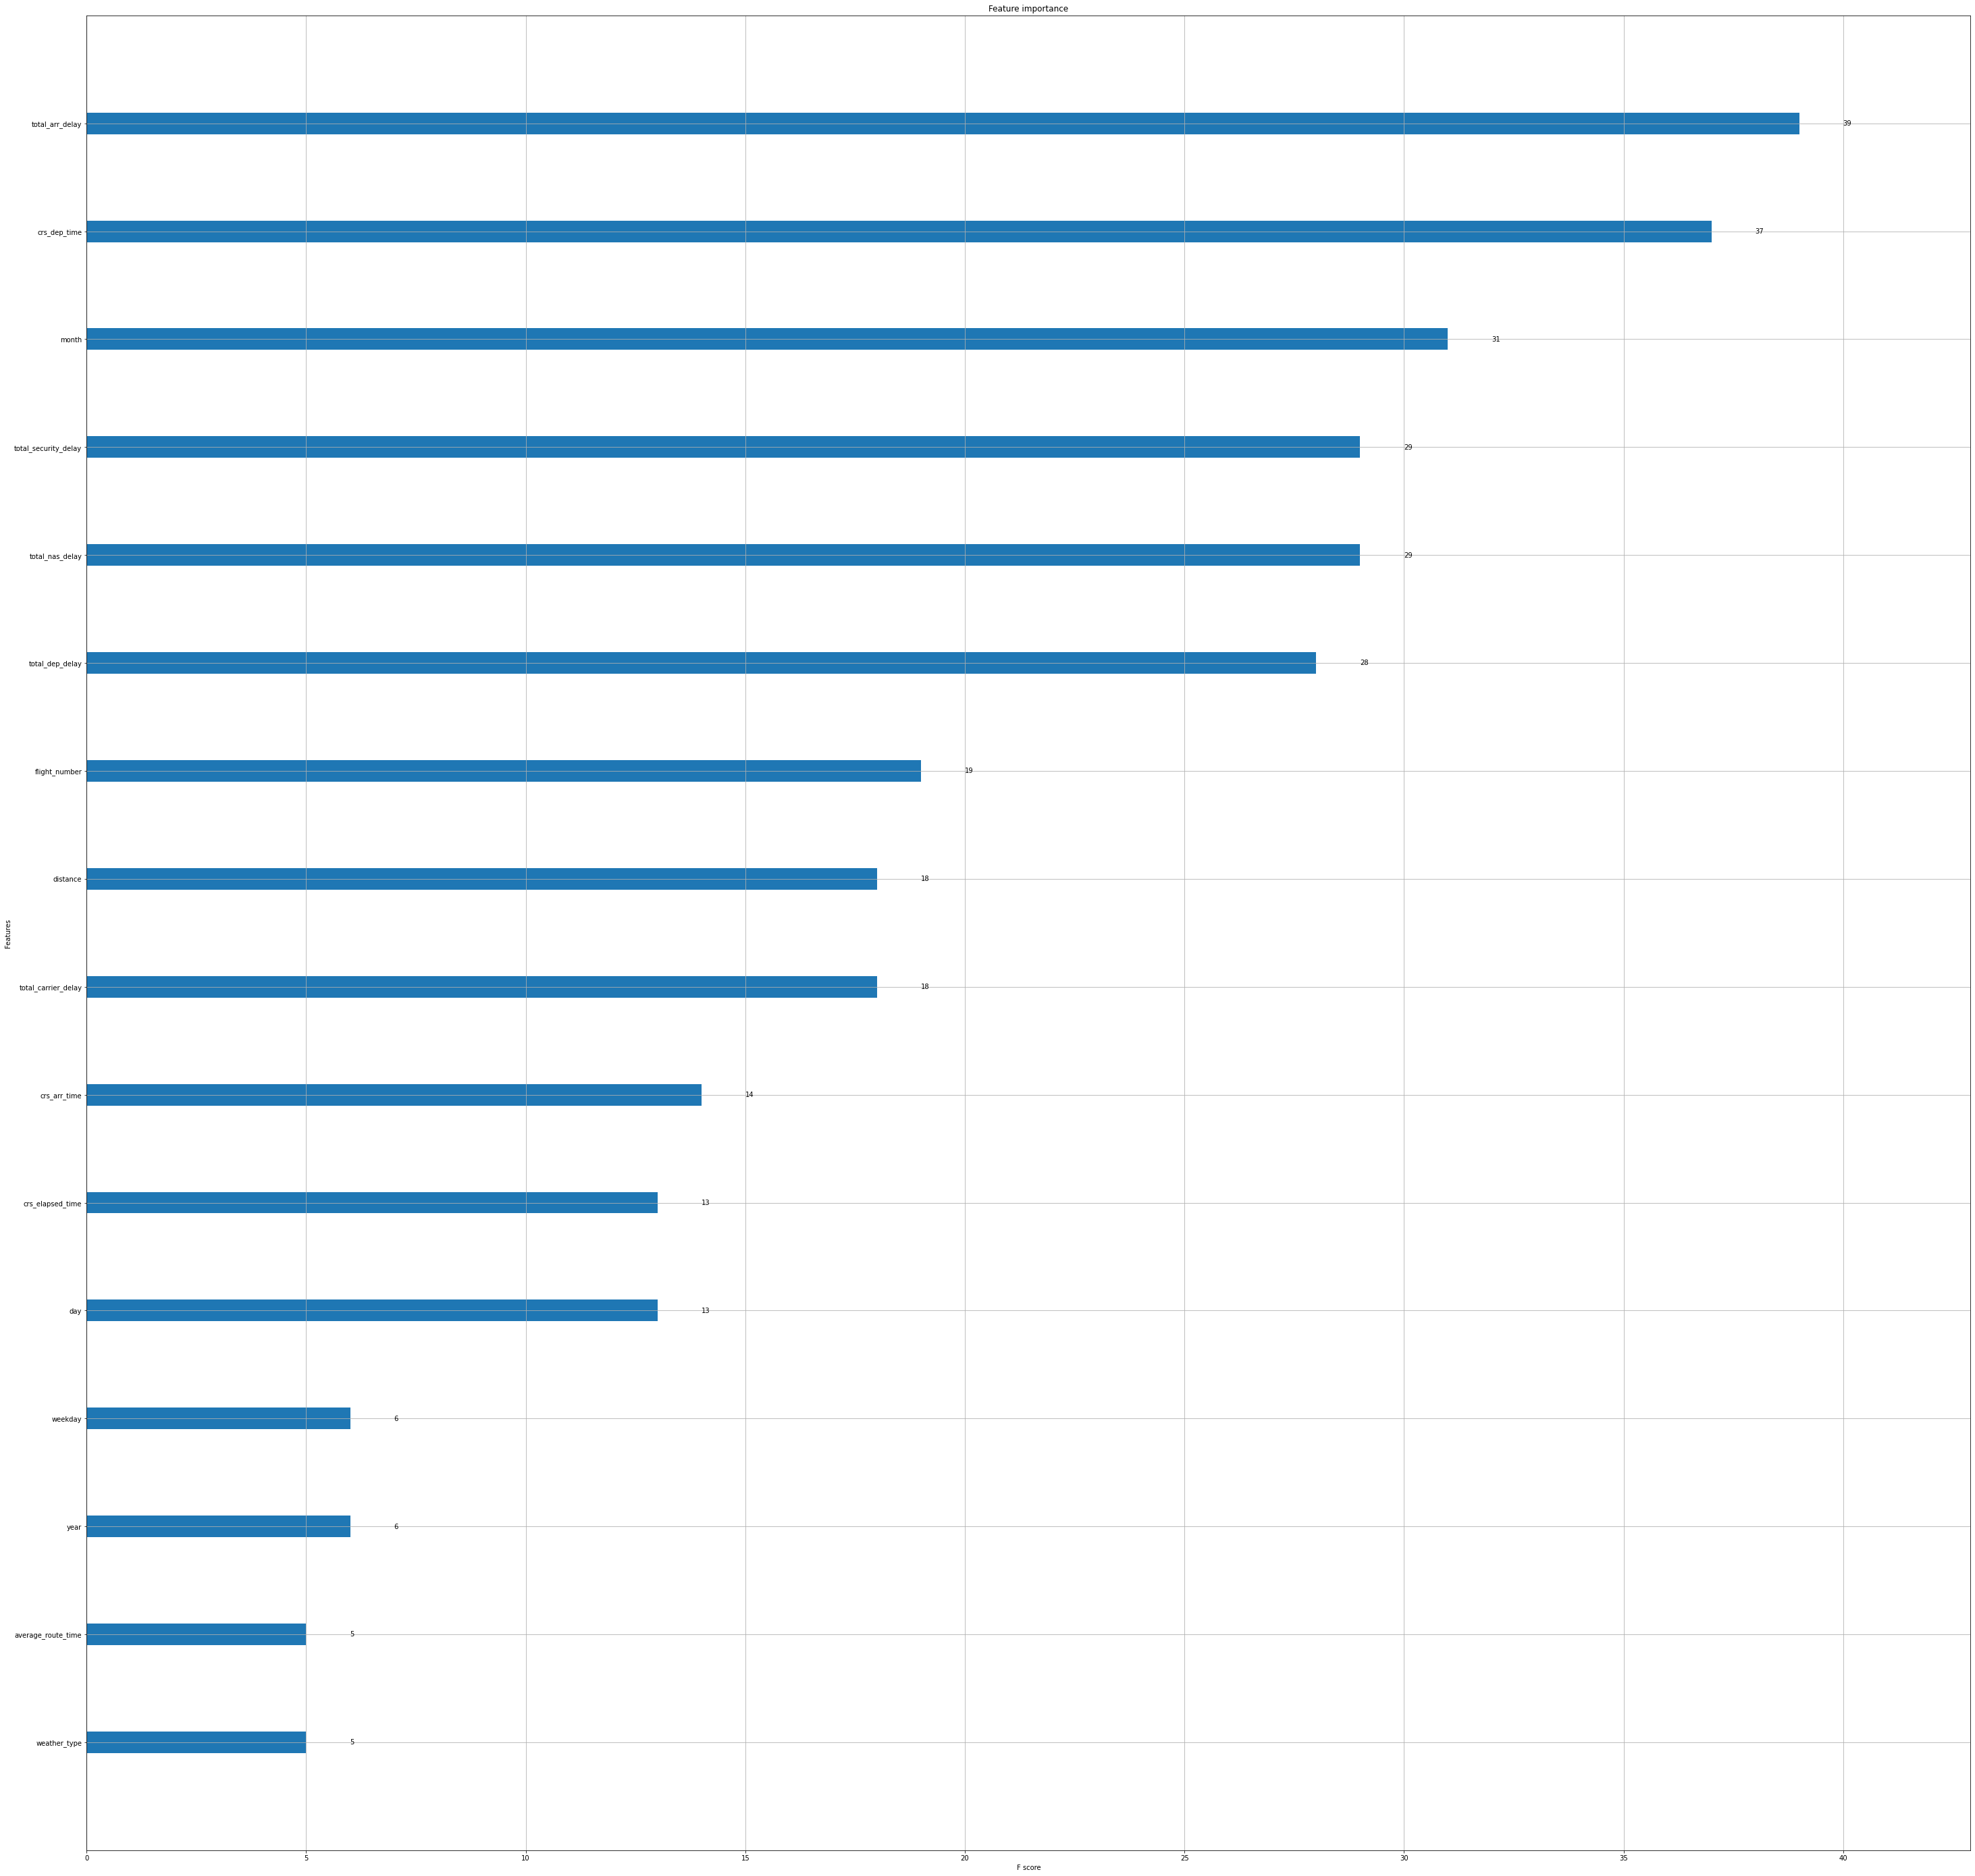

In [117]:
#Examine the importance of each feature column in the original data set with the model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [ ]:
params = {'objective':'reg:squarederror', 'colsample_bytree' : 0.3, 'learning_rate' : 0.1,
                'max_depth' : 5, 'alpha' : 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="mae", as_pandas=True, seed=123)

print('XGBoost Model Cross-validation MAE is: ',(cv_results["test-mae-mean"]).tail(1))

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# CV model
model = xg_reg
kfold = StratifiedKFold(n_splits=10)
results = cross_val_score(model, X_test, y_test, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

##### Linear Regression

In [151]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# creating linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_lr = lr.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_lr)))
print('Model R2 Score is: ',r2_score(y_test,y_lr))

Model RMSE is:  41.04430751169987
Model R2 Score is:  0.09010982648453558


In [152]:
from numpy import mean
from numpy import absolute

#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple linear regression model
model = lr

#use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print('Linear Model Cross-validation MAE is: ',mean(absolute(scores)))

Linear Model Cross-validation MAE is:  22.952193890281674


##### Ridge/Lasso Regression

In [153]:
ridgereg = Ridge(alpha=0.001,normalize=True)
ridge = ridgereg.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_ridge))

lassoreg = Lasso(alpha=0.001,normalize=True)
lasso = lassoreg.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_lasso))

Model RMSE is:  41.04431207827157
Model R2 Score is:  0.0901096240165592
Model RMSE is:  41.15480814567792
Model R2 Score is:  0.08520396791066198


In [154]:
ridgereg = Ridge(alpha=0.001,normalize=True)
ridge = ridgereg.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_ridge))

lassoreg = Lasso(alpha=0.001,normalize=True)
lasso = lassoreg.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_lasso))

Model RMSE is:  41.04431207827157
Model R2 Score is:  0.0901096240165592
Model RMSE is:  41.15480814567792
Model R2 Score is:  0.08520396791066198
